<a href="https://colab.research.google.com/github/andrew-veriga/Tensorflow-labs/blob/master/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Прежде чем начать, убедитесь, что вы используете Python 3 и GPU. В пункте меню *RunTime->Change runtime type* установите нужные параметры. 

Часть кода потребует установки последней версии TensoFlow 2.х. Поэтому убедитесь, что она у вас установлена, запустив ячейку ниже. Если у вас стоит версия Tensorflow 1.х - запустите ячейку сверху этого текста. Если вы это сделете и увидите сообщение о перезапуске runtime, - перезапустите. Убедитесь еще раз, что у вас все еще включены опции Python 3 и GPU, и снова запустите ячейку ниже. В результате вы должны увидеть, что теперь установлен TensoFlow 2.х .

In [2]:
import tensorflow as tf
print(tf.__version__)


2.2.0-rc2


Следующий блок кода содержит много того, что вы видели на предыдущих уроках. Он создаст временной ряд `series` с трендом, сезонностью и шумом. Вы увидите этот синтетический временной ряд на графике.

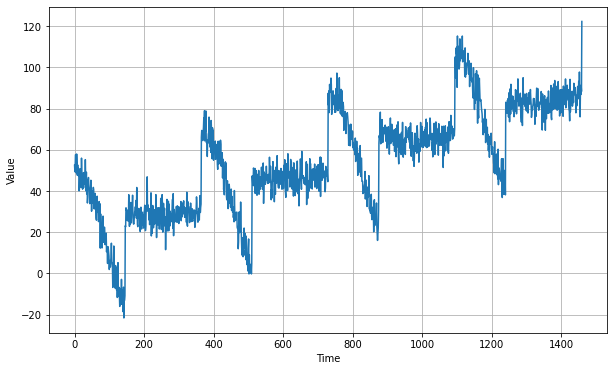

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")

series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


Теперь, чтобы создать отдельные обучающий и валидационный наборы, мы просто разделим массив `series` на две части в точке с индексом 1000. И выведем их графики.

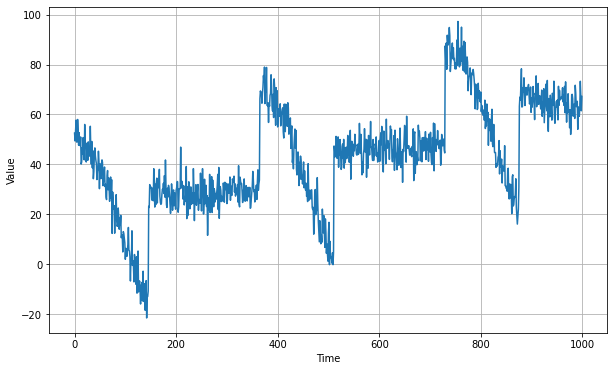

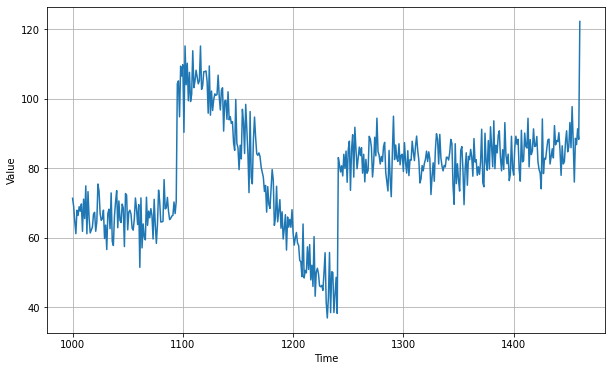

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

И снова убедимся: в тренировочном наборе сохраняется и сезонность, и восходящий тренд. Также есть некоторый шум. 

Набор валидации аналогичен, и хотя графики могут выглядеть по-разному. Проверьте ось x, и вы можете видеть, что это тот же шаблон с немного увеличенным масштабом.

# Наивный прогноз


Первое самое простое предсказание: просто предсказать значение в период времени плюс один. Создадим данные `naive_forecast`, которые будут просто отставать от валидационных данных на один шаг времени:

In [0]:
naive_forecast = series[split_time - 1:-1]

Оригинальная серия будет синей, а предсказанная - оранжевой

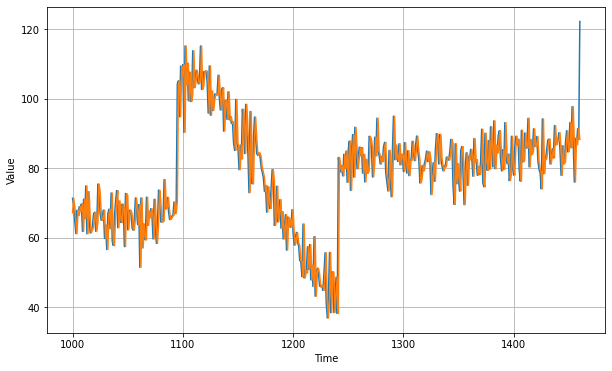

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Трудно разобраться, давайте немного увеличим:

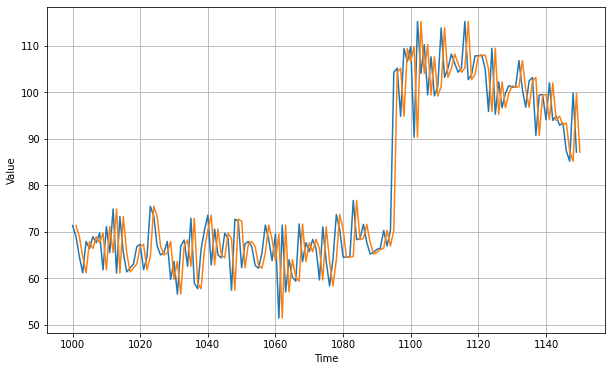

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Вы можете видеть, что наивный прогноз отстает на 1 шаг от временного ряда.

Теперь давайте вычислим среднеквадратическую ошибку и среднюю абсолютную ошибку между наивным прогнозом и нашим временным рядом в периоде валидации:

In [12]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827538
5.9379086


Мы будем называть это нашей базовой линией. То есть, это те метрики, с которыми мы будем сверяться при оценке производительности модели.

Теперь давайте попробуем скользящее среднее:

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

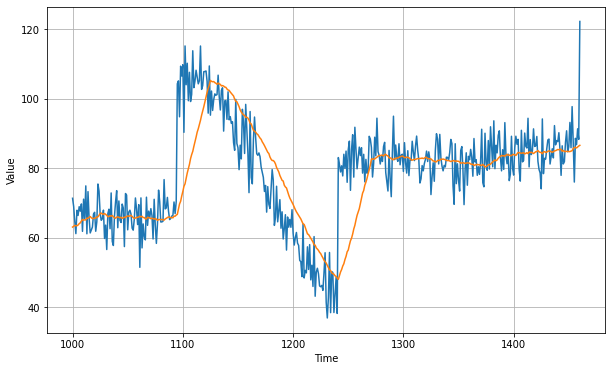

In [14]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [15]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

In [0]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

In [0]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

In [0]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

In [0]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())